In [1]:
import pandas as pd
import numpy as np
import sys
import os
import itertools
import matplotlib.pyplot as plt
from nltk.corpus import words
from scipy.stats import entropy
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
sys.path.append( '/Users/kgray/Downloads/artemis/src/scripts' )
from generate_entropy_data import generate_shannon_entropy_score
from domain_tools import get_domain_parts
from parse_json import parse_json


In [2]:
random_seed = 355


# Stage 1: DGA Detection
Good explanation of DGA (Todo: Pull some of this in and reference): https://zvelo.com/domain-generation-algorithms-dgas/

### Alternate DGA dataset options
* Pre-generated
  * https://github.com/chrmor/DGA_domains_dataset (675,000 domains)
  * https://data.mendeley.com/datasets/y8ph45msv8/1 (dataset and howto to generate ourself)
  * https://dgarchive.caad.fkie.fraunhofer.de/welcome/
* Real
  * https://github.com/andrewaeva/DGA (6+ years old)
  * https://data.netlab.360.com/dga/
* Generate on our own
  * https://github.com/baderj/domain_generation_algorithms (likely candidate, updated recently)

### Known DGA Research (dump list for now)
* Reviewed
  * https://webdiis.unizar.es/~ricardo/files/papers/SRS-ESWA-19.pdf
* Skimmed
* To Review
  * https://arxiv.org/pdf/2101.00521.pdf
  * https://pureadmin.qub.ac.uk/ws/portalfiles/portal/201568633/MaldomDetector_A_System_for_Detecting.pdf
    * https://dgarchive.caad.fkie.fraunhofer.de/welcome/ (Referenced the DGArchive, which may be worth looking into...requires access)
    
### Recent News
* https://www.catonetworks.com/blog/the-dga-algorithm-used-by-dealply-and-bujo/

In [69]:
# Re-using clean/dga datasets from https://github.com/jselvi/phd/tree/master/dga
# Source paper: https://webdiis.unizar.es/~ricardo/files/papers/SRS-ESWA-19.pdf
# Title: Detection of Algorithmically Generated Malicious Domain Names using Masked N-Grams
# Authors: Jose Selvi, Ricardo J. Rodriguez, Emilio Soria
# License: BSD 3-Clause License
# Should look at generating our own or getting a list of registered DGA domains.
# Without registered domains, we can't calculate domain age. However, domain age is 
# highly dependent on when the domain was identifed as malicious and may not be a good
# feature to use.
clean_domains = pd.read_csv('https://raw.githubusercontent.com/jselvi/phd/master/dga/clean-alexa-32k.txt', header=None)
#dga_domains = pd.read_csv('https://raw.githubusercontent.com/jselvi/phd/master/dga/dga-bader-32k.txt', header=None)
dga_domains = pd.read_csv('../data/raw/dga_data.csv')


In [70]:
clean_domains.rename(columns={0: 'domain'}, inplace=True)
clean_domains['dga'] = False
clean_domains.head()


,domain,dga
0,google.com,False
1,youtube.com,False
2,facebook.com,False
3,baidu.com,False
4,yahoo.com,False


In [71]:
#dga_domains.rename(columns={0: 'domain_name'}, inplace=True)
#dga_domains['dga'] = 1
dga_domains.drop(columns=['algorithm'], inplace=True)
dga_domains.head()


,domain,dga
0,vrelipftnrpljqmsygyauxqc.org,True
1,hgwztctvsohl.biz,True
2,iercuwfjzohojzfeoxnpuu.biz,True
3,toomkgkqulapqtxqzfepu.org,True
4,opojwuisyuhgnxyrqqx.net,True


In [72]:
# Combine clean/dga datasets
dga_dataset = pd.concat([clean_domains, dga_domains]).reset_index().drop(columns='index')


In [73]:
word_list = set(words.words())
word_length_threshold = 3
# Remove words with less than 4 characters
word_list = [x for x in word_list if len(x) > word_length_threshold ]

# Todo: Stop searching when domain becomes all numbers or spaces
# Search for words in domain string. Remove the words from the domain when a match occurs,
# otherwise we could have more word characters in a domain than the length of a string.
# Should consider that shorter words may match first simply due to coming first in
# the dictionary. How can we account for that?
def find_words(domain, word_list, verbose=False):
    word_count = 0
    for word in word_list:
        if word in domain:
            word_count += len(word)
            domain = domain.replace(word, ' ')
            if verbose: print(word + " matched in " + domain)
            if verbose: print("updated domain is now " + domain)
    return(word_count)


In [74]:
def uncommon_letters(string_value):
    # https://en.wikipedia.org/wiki/Letter_frequency
    least_common_letters = ("q", "x", "z", "j", "w")
    letter_count = 0
    for i in range(0,len(string_value)):
        if string_value[i] in least_common_letters:
            letter_count += 1
    return(letter_count)


In [75]:
# Generate features
# Todo: Turn this into a function as well
dga_dataset['entropy'] = dga_dataset['domain'].apply(lambda x: generate_shannon_entropy_score(x))
dga_dataset['domain_root'] = dga_dataset['domain'].apply(lambda x: ''.join(get_domain_parts(x)[:2]))
dga_dataset['length']= dga_dataset['domain_root'].str.len()
# Consider making this a ratio of count/length (or the implications for leaving it as-is)
dga_dataset['uncommon_letters'] = dga_dataset['domain_root'].apply(lambda x: uncommon_letters(x))
dga_dataset['word_count'] = dga_dataset['domain_root'].apply(lambda x: find_words(x, word_list))
dga_dataset['word_ratio'] = dga_dataset['word_count'] / dga_dataset['length']
# Todo: Find better solution for domains that have no root, likely due to confusion with
# what a TLD is. For now, drop NaN (only 84 rows).
dga_dataset.dropna(inplace=True)


In [76]:
# Check for NaN rows
dga_dataset[dga_dataset.isna().any(axis=1)]

,domain,dga,entropy,domain_root,length,uncommon_letters,word_count,word_ratio


In [77]:
# Reproduce "masked n-gram" idea found in https://webdiis.unizar.es/~ricardo/files/papers/SRS-ESWA-19.pdf.
# Todo: Ensure we're not missing any character types.
# n = number; s = symbol; v = vowel, c = consonant
def mask_string(string_value):
    symbols = ("-")
    vowels = ("a","e","i","o","u")
    masked_domain = []
    for i in range(0,len(string_value)):
        masked_value = ""
        if string_value[i].isnumeric():
            masked_value = "n"
        elif string_value[i] in symbols:  
            masked_value = "s"
        elif string_value[i] in vowels:  
            masked_value = "v"
        else:  
            masked_value = "c"
        masked_domain.append(masked_value)
    return ''.join(masked_domain)


In [78]:
# Create all possible combinations of masked n-gram values for features.
ngram_size=4
masked_ngram_values = ['n', 's', 'v', 'c']
ngram_combinations = [''.join(i) for i in itertools.product(masked_ngram_values, repeat = ngram_size)]


In [79]:
dga_dataset['masked_domain'] = dga_dataset['domain_root'].apply(lambda x: mask_string(x))
dga_dataset['masked_ngrams'] = dga_dataset['masked_domain'].apply(lambda x: [x[i:i+ngram_size] for i in range(len(x)-ngram_size+1)])

# One-hot encode masked ngrams and combine with other features. Will not make sparse.
# Todo: Make this a function that returns the one-hot encoded dataframe, since we do this same thing below.
mlb = MultiLabelBinarizer()
dga_dataset = dga_dataset.join(pd.DataFrame(mlb.fit_transform(dga_dataset.pop('masked_ngrams')),
                            index=dga_dataset.index, columns=mlb.classes_))


In [80]:
# Add in missing features to make sure this is compatible with the model created below.
missing_features = list(set(ngram_combinations) - set(mlb.classes_))
temp_dga_dataset = pd.DataFrame(index=dga_dataset.index, columns=missing_features)
temp_dga_dataset = temp_dga_dataset.replace(np.nan, 0)

dga_dataset = dga_dataset.join(temp_dga_dataset)


In [81]:
# Prepare domain for modeling 
dga_dataset = dga_dataset.set_index('domain').drop(columns=['domain_root', 'masked_domain'])


In [82]:
dga_dataset


,dga,entropy,length,uncommon_letters,word_count,word_ratio,cccc,cccn,cccs,cccv,...,nsvs,nssc,snsn,nvsc,cnsn,scsn,nnsv,sncs,vncs,nsvv
domain,,,,,,,,,,,,,,,,,,,,,
google.com,False,2.646439,6,0,4,0.666667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
youtube.com,False,3.095795,7,0,4,0.571429,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
facebook.com,False,3.022055,8,0,8,1.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
baidu.com,False,3.169925,5,0,0,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
yahoo.com,False,2.641604,5,0,5,1.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hqepnmqewn.net,True,2.985228,10,3,0,0.000000,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
rsrsemnren.org,True,2.807355,10,0,0,0.000000,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
spewqmspma.biz,True,3.378783,10,2,4,0.400000,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [83]:
y_col = 'dga'
y = dga_dataset[y_col]
X = dga_dataset[dga_dataset.columns.drop(y_col)]
#model = RandomForestClassifier(random_state=random_seed)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_seed)
#n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
#print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [85]:
model = RandomForestClassifier(random_state=random_seed)
model.fit(X_train, y_train)
yhat = model.predict(X_test)
acc = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % acc)

Accuracy: 0.965


In [86]:
#importance = model.feature_importances_
#for i,v in enumerate(importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))
#plt.bar([x for x in range(len(importance))], importance)
#plt.show()
features = {}
for feature, importance in zip(X.columns, model.feature_importances_):
    features[feature] = importance
dict(sorted(features.items(), key=lambda item: item[1], reverse=True))

{'length': 0.1877307148167212,
 'word_ratio': 0.16994224013563602,
 'uncommon_letters': 0.13281157369337762,
 'entropy': 0.11886026091696011,
 'word_count': 0.1110060287761611,
 'cccc': 0.06369378007448731,
 'cccv': 0.022102729172552904,
 'ccvc': 0.018775707545174422,
 'vccc': 0.018073055153237396,
 'vcvc': 0.01638708870874631,
 'vccv': 0.015908191409645004,
 'cvcv': 0.01386699013563954,
 'cvcc': 0.0100230200219245,
 'ccvv': 0.009543616161205335,
 'cvvc': 0.00890179313602158,
 'vvcc': 0.007943268591182105,
 'vvcv': 0.00636856259206229,
 'vcvv': 0.004367404014038964,
 'scvc': 0.0039048558917424586,
 'nnnc': 0.0036541210930658057,
 'nncn': 0.0029996899206937125,
 'ncnn': 0.0028252743652607097,
 'vvvc': 0.002460953885378087,
 'cvvv': 0.0023582342489889972,
 'nnnn': 0.002323276507496057,
 'cnnc': 0.0020888211083559356,
 'cscv': 0.0019132580916330594,
 'cnnn': 0.0016922967977037481,
 'cccn': 0.001528718047106522,
 'nvnn': 0.0015052766774798052,
 'nncc': 0.0013974766531123506,
 'nccc': 0.001

## Load Artemis Primary Dataset

Will use this dataset in Stage 1 for two purposes:
1. Evaluate benign domains (malicious=False) to ensure DGA predictions are low.
2. Filter out malicious domains (malicious=True) that are predicted to be DGAs. This will leave us with a set of malicious domains that will are assumed to have been registered and used legitimately.

In [23]:
primary_dataset = pd.read_csv('../data/processed/whois_data.csv', low_memory=False)

In [24]:
primary_dataset

,domain,redacted,country,dnssec,domain_name,emails_1,emails_2,name_servers_1,name_servers_2,name_servers_3,...,dns_rec_a_cc,dns_rec_a_org,dns_rec_mx_cc,dns_rec_mx_org,malicious,days_between_creations,days_since_creation,days_between_updates,days_since_update,days_until_expiration
0,google.com,False,US,unsigned,GOOGLE.COM;google.com,abusecomplaints@markmonitor.com,whoisrequest@markmonitor.com,NS1.GOOGLE.COM,NS2.GOOGLE.COM,NS3.GOOGLE.COM,...,us,google llc,us,google llc,False,0.0,8960.0,0.0,931.0,2362.0
1,facebook.com,False,US,unsigned,FACEBOOK.COM,abusecomplaints@registrarsafe.com,domain@fb.com,A.NS.FACEBOOK.COM,B.NS.FACEBOOK.COM,C.NS.FACEBOOK.COM,...,us,"facebook, inc.",us,"facebook, inc.",False,0.0,9130.0,0.0,61.0,3289.0
2,youtube.com,False,US,unsigned,YOUTUBE.COM;youtube.com,abusecomplaints@markmonitor.com,whoisrequest@markmonitor.com,NS1.GOOGLE.COM,NS2.GOOGLE.COM,NS3.GOOGLE.COM,...,us,google llc,us,google llc,False,0.0,6250.0,0.0,73.0,324.0
3,twitter.com,False,US,unsigned,TWITTER.COM;twitter.com,domainabuse@cscglobal.com,domains@twitter.com,A.R06.TWTRDNS.NET,B.R06.TWTRDNS.NET,C.R06.TWTRDNS.NET,...,us,twitter inc.,us,google llc,False,0.0,8102.0,0.0,70.0,299.0
4,instagram.com,False,US,unsigned,INSTAGRAM.COM,abusecomplaints@registrarsafe.com,domain@fb.com,A.NS.INSTAGRAM.COM,B.NS.INSTAGRAM.COM,C.NS.INSTAGRAM.COM,...,us,"facebook, inc.",us,"proofpoint, inc.",False,0.0,6506.0,0.0,140.0,3355.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6505,ewakyc72.top,True,RU,unsigned,ewakyc72.top,NaN,NaN,a.dnspod.com,b.dnspod.com,A.DNSPOD.COM,...,na,na,na,na,True,1.0,252.0,17.0,236.0,113.0
6506,ewazqx71.top,True,RU,unsigned,ewazqx71.top,NaN,NaN,a.dnspod.com,b.dnspod.com,A.DNSPOD.COM,...,na,na,na,na,True,1.0,252.0,17.0,236.0,113.0
6507,rebornx.duckdns.org,True,FR,unsigned;Unsigned,DUCKDNS.ORG;duckdns.org,abuse@support.gandi.net,25e6a5dc339baa71337fd929254287e6-1702436@conta...,NS1.DUCKDNS.ORG,NS2.DUCKDNS.ORG,NS3.DUCKDNS.ORG,...,nl,stop the war in ukraine!,nl,stop the war in ukraine!,True,0.0,3272.0,0.0,122.0,2572.0
6508,mail.dipiluminacion.com,False,MX,unsigned,DIPILUMINACION.COM;dipiluminacion.com,abuso@akky.mx,abuse@akky.mx,NS1.MYHOSTINGPACK.COM,NS2.MYHOSTINGPACK.COM,ns1.myhostingpack.com,...,us,"digitalocean, llc",us,"psinet, inc.",True,0.0,2073.0,0.0,245.0,118.0


In [25]:
# Generate features
# Already calculated for us via make_dataset process.
#primary_dataset['entropy'] = primary_dataset['domain'].apply(lambda x: generate_shannon_entropy_score(x))
primary_dataset['domain_root'] = primary_dataset['domain'].apply(lambda x: ''.join(get_domain_parts(x)[:2]))
primary_dataset['length']= primary_dataset['domain_root'].str.len()
primary_dataset['uncommon_letters'] = primary_dataset['domain_root'].apply(lambda x: uncommon_letters(x))
primary_dataset['word_count'] = primary_dataset['domain_root'].apply(lambda x: find_words(x, word_list))
primary_dataset['word_ratio'] = primary_dataset['word_count'] / primary_dataset['length']


In [26]:
plot_features = ['entropy', 'length', 'uncommon_letters', 'word_count', 'word_ratio', 'malicious']
primary_dataset.groupby('malicious')[plot_features].describe()


entropy                                                         \
            count      mean       std  min       25%       50%       75%   
malicious                                                                  
False      3989.0  2.359456  0.760036 -0.0  1.921928  2.521641  2.921928   
True       2521.0  3.085939  0.479728 -0.0  2.750000  3.084963  3.418296   

                     length             ... word_count       word_ratio  \
                max   count       mean  ...        75%   max      count   
malicious                               ...                               
False      3.879664  3989.0   7.394334  ...        7.0  20.0     3898.0   
True       4.395999  2521.0  13.083300  ...        8.0  26.0     2520.0   

                                                                  
               mean       std  min  25%       50%       75%  max  
malicious                                                         
False      0.458804  0.380516  0.0  0.0  0.555556  0.800000  1.0  
True       0.311871  0.299456  0.0  0.0  0.333333  0.555556  1.0  

[2 rows x 40 columns]

/var/folders/zk/_l6jn98j1ws6ndxrzcw2dh4m0000gn/T/ipykernel_49350/1468203506.py:5: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  boxplot_before_dga_dict = primary_dataset[plot_features].boxplot(


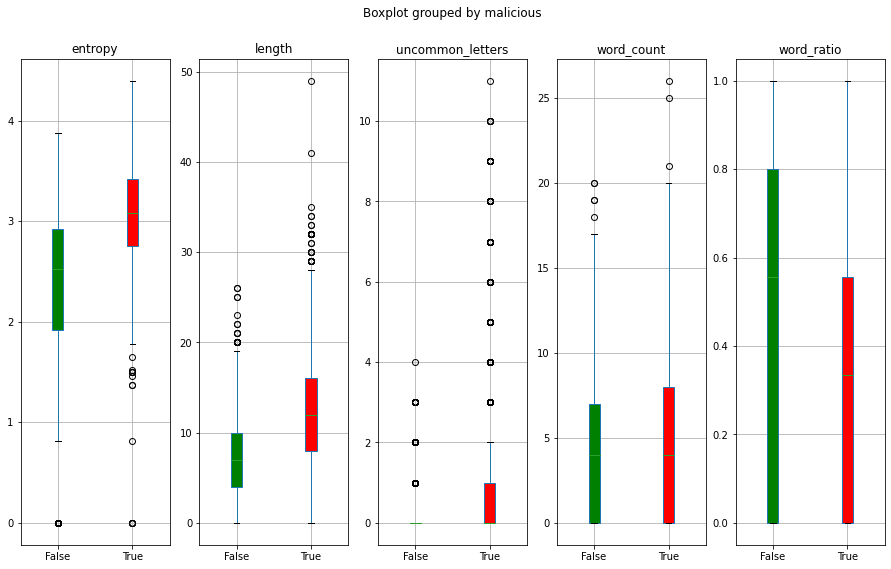

In [27]:
plt.rcParams["figure.figsize"] = [15, 9]

fig, axes = plt.subplots(1, 5)

boxplot_before_dga_dict = primary_dataset[plot_features].boxplot(
    by="malicious", ax=axes, figsize=(6,4),
    return_type='both',
    patch_artist = True
)

colors = ['g', 'r']
for row_key, (ax,row) in boxplot_before_dga_dict.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])
        
plt.show()


In [28]:
dga_features = ['domain', 'domain_root']
dga_features.extend(plot_features)
primary_dga_detection = primary_dataset[dga_features].copy()
primary_dga_detection['masked_domain'] = primary_dga_detection['domain_root'].apply(lambda x: mask_string(x))
primary_dga_detection['masked_ngrams'] = primary_dga_detection['masked_domain'].apply(lambda x: [x[i:i+ngram_size] for i in range(len(x)-ngram_size+1)])
# Todo: Find better solution for domains that have no root, likely due to confusion with
# what a TLD is. For now, drop NaN.
primary_dga_detection.dropna(inplace=True)


# One-hot encode masked ngrams and combine with other features. Will not make sparse.
mlb = MultiLabelBinarizer()
primary_dga_detection = primary_dga_detection.join(pd.DataFrame(mlb.fit_transform(primary_dga_detection.pop('masked_ngrams')),
                            index=primary_dga_detection.index, columns=mlb.classes_))


In [29]:
# Add in missing features to make sure this is compatible with the model created above.
missing_features = list(set(ngram_combinations) - set(mlb.classes_))
temp_primary_dga_detection = pd.DataFrame(index=primary_dga_detection.index, columns=missing_features)
temp_primary_dga_detection = temp_primary_dga_detection.replace(np.nan, 0)

primary_dga_detection = primary_dga_detection.join(temp_primary_dga_detection)


In [30]:
# Prepare domain for modeling 
primary_dga_detection = primary_dga_detection.set_index('domain').drop(columns=['domain_root', 'masked_domain'])

# Reorder features so they match domains_df (otherwise sklearn will complain)
reordered_columns = domains_df.columns
reordered_columns = [item.replace('dga', 'malicious') for item in reordered_columns]
primary_dga_detection = primary_dga_detection.reindex(reordered_columns, axis=1)


In [31]:
primary_dga_detection


,malicious,entropy,length,uncommon_letters,word_count,word_ratio,cccc,cccn,cccs,cccv,...,nsvs,nssc,snsn,nvsc,cnsn,scsn,nnsv,sncs,vncs,nsvv
domain,,,,,,,,,,,,,,,,,,,,,
google.com,False,1.918296,6,0,4,0.666667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
facebook.com,False,2.750000,8,0,8,1.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
youtube.com,False,2.521641,7,0,4,0.571429,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
twitter.com,False,2.128085,7,1,4,0.571429,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
instagram.com,False,2.947703,9,0,4,0.444444,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ewakyc72.top,True,3.000000,8,1,4,0.500000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
ewazqx71.top,True,3.000000,8,4,0,0.000000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
rebornx.duckdns.org,True,3.378783,14,1,10,0.714286,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Predict DGA on benign domains (number of DGA predictions should be low)
X_benign = primary_dga_detection[primary_dga_detection['malicious'] == False].drop(
                                columns=['malicious'])


In [33]:
# Make predictions on benign domains
y_benign = model.predict(X_benign)


In [34]:
count = np.count_nonzero(y_benign == 1)
print("Benign domains predicted as DGA: " + str(round(count / len(y_benign) * 100, 2)) + "%")


Benign domains predicted as DGA: 3.34%


In [35]:
# Predict DGA on malicious domains (number of DGA predictions should be higher)
X_malicious = primary_dga_detection[primary_dga_detection['malicious'] == True].drop(
                                columns=['malicious'])


In [36]:
# Make predictions on benign domains
y_malicious = model.predict(X_malicious)


In [37]:
count = np.count_nonzero(y_malicious == 1)
print("Malicious domains predicted as DGA: " + str(round(count / len(y_malicious) * 100, 2)) + "%")


Malicious domains predicted as DGA: 32.94%


In [38]:
# Todo: Find a more elegant way to do this.
# Remove DGA domains from dataframe.
malicious_temp_df = primary_dga_detection[primary_dga_detection['malicious'] == True].copy()
malicious_temp_df['dga'] = y_malicious
malicious_dga_domain_list = list(malicious_temp_df[malicious_temp_df['dga'] == 1].index)
malicious_nondga_domain_list = list(malicious_temp_df[malicious_temp_df['dga'] == 0].index)
# Drop DGA domains from primary dataset
# Temporarily set index to domain
primary_dataset.set_index('domain', inplace=True)
primary_dataset.drop(malicious_temp_df[malicious_temp_df['dga'] == 1].index, inplace=True)
#primary_dataset = primary_dataset.reset_index().rename(columns={'index': 'domain'})


In [39]:
print("Number of malicious domains predicted to be DGA: " + str(len(malicious_dga_domain_list)) + '\n')
print(malicious_dga_domain_list)


Number of malicious domains predicted to be DGA: 830

['crmweb.info', 'autodiscover.karlamejia.com', 'unpszx0ql5.cloud', 'unpszx0ql5.cloud', 'unpszx0ql5.cloud', 'unpszx0ql5.cloud', 'unpszx0ql5.cloud', 'unpszx0ql5.cloud', 'unpszx0ql5.cloud', 'unpszx0ql5.cloud', 'rt7j4qoiqh.cloud', 'xp0tztbd3s.cloud', 'yke6jpq69x.cloud', 'heexcnqklq.shop', 'l4uxr5s2yq.online', 'lih2wbii62.shop', 'ltpyi8i70o.shop', 'p2jnahbccw.shop', 'qau6z4582u.shop', 'r53z7jfphl.online', 'rofbiqr0wx.online', 'veermckenzie483.website', 'zackaryfritz357.website', 'matasmcmanus3256.website', 'skylarkelley215.website', 'finleymcghee458.website', 'francescarobertson842.website', 'kaitlynmcneil275.website', 'ayishajimenez232.top', 'eilidhmcarthu458r.website', 'zmi692fchugg4.world', 'hn6dga8vkkm9ah.world', 'hqaxkbbma05u48.agency', 'itx02gler3uk5.digital', 'mng7wu9tx22isva.digital', 'pa49ed5cxjrdj.digital', 'rwaehpjqfyyvfmam7.today', 'sj04xb2nh59mg5.agency', 'v1xmw5x3phqc.digital', 'x1zu4ksval1hjh5.today', 'yxjukwts3tt.today', 

In [40]:
print("Number of malicious domains predicted to not be DGA: " + str(len(malicious_nondga_domain_list)) + '\n')
print(malicious_nondga_domain_list)


Number of malicious domains predicted to not be DGA: 1690

['reseptors.com', 'contentcdns.net', 'izocab.com', 'eleccom.shop', 'artanddesign.one', 'accessunited-bank.com', 'strawberry.kids-singer.net', 'ledcaopingdeng.com', 'krezol-group.com', 'badgoodreason.com', 'cooldogblunts.com', 'coolbearblunts.com', 'betleverdoom.quest', 'blutimeddoom.quest', 'damleverdstar.cfd', 'dingsteddoom.quest', 'flametradoom.quest', 'flamsgindstar.cfd', 'navegandostar.cfd', 'neitelandstar.cfd', 'aeringwebstar.cfd', 'anintenddoom.quest', 'irsgetwell.net', 'solramos2643.website', 'tainemerritt6538.website', 'mcauleysampson123.website', 'mohammodhealy32.website', 'nancydouglas67.website', 'nathaliechang1243.website', 'rayagreenaway5483.website', 'robbiequintero23.website', 'roryblaese13.website', 'serenalaingw6.website', 'enyaallan7604.website', 'franciscomarshall66.website', 'gutogaines456.website', 'hughmackay66479.website', 'kayneedge436.website', 'khadeejahdunn235.website', 'louisadickens483.website', 'am

/var/folders/zk/_l6jn98j1ws6ndxrzcw2dh4m0000gn/T/ipykernel_49350/189177806.py:3: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  boxplot_after_dga_dict = primary_dataset[plot_features].boxplot(


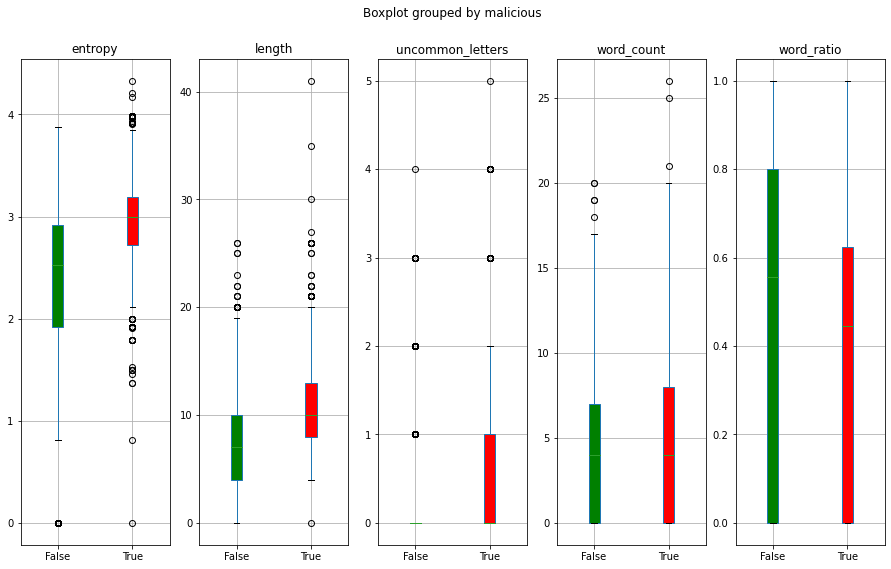

In [41]:
fig, axes = plt.subplots(1,5)

boxplot_after_dga_dict = primary_dataset[plot_features].boxplot(
    by="malicious", ax=axes, figsize=(6,4),
    return_type='both',
    patch_artist = True
)

colors = ['g', 'r']
for row_key, (ax,row) in boxplot_after_dga_dict.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])
plt.show()


In [42]:
primary_dataset.groupby('malicious')[plot_features].describe()


entropy                                                         \
            count      mean       std  min       25%       50%       75%   
malicious                                                                  
False      3989.0  2.359456  0.760036 -0.0  1.921928  2.521641  2.921928   
True       1691.0  2.947978  0.421291  0.0  2.723704  3.000000  3.189898   

                     length             ... word_count       word_ratio  \
                max   count       mean  ...        75%   max      count   
malicious                               ...                               
False      3.879664  3989.0   7.394334  ...        7.0  20.0     3898.0   
True       4.329283  1691.0  10.855707  ...        8.0  26.0     1690.0   

                                                               
               mean       std  min  25%       50%    75%  max  
malicious                                                      
False      0.458804  0.380516  0.0  0.0  0.555556  0.800  1.0  
True       0.401387  0.297778  0.0  0.0  0.444444  0.625  1.0  

[2 rows x 40 columns]

# Stage 2: Legitimate Domain Malicious Use Detector

In [43]:
# Review all features available.
print(list(primary_dataset.columns))

['redacted', 'country', 'dnssec', 'domain_name', 'emails_1', 'emails_2', 'name_servers_1', 'name_servers_2', 'name_servers_3', 'name_servers_4', 'name_servers_5', 'name_servers_6', 'name_servers_7', 'name_servers_8', 'org', 'registrar', 'state', 'status_1', 'status_2', 'status_3', 'status_4', 'status_5', 'status_6', 'status_7', 'status_8', 'status_9', 'status_10', 'status_11', 'status_12', 'updated_date', 'whois_server', 'address', 'city', 'creation_date', 'expiration_date', 'name', 'zipcode', 'emails_3', 'name_servers_9', 'name_servers_10', 'name_servers_11', 'name_servers_12', 'name_servers_13', 'name_servers_14', 'name_servers_15', 'name_servers_16', 'emails_4', 'name_servers_17', 'emails', 'name_servers', 'status', 'domain__id', 'registrant_country', 'registrant_name', 'registrant_state_province', 'registrar_id', 'registrar_url', 'admin', 'admin_application_purpose', 'admin_city', 'admin_country', 'admin_email', 'admin_id', 'admin_nexus_category', 'admin_organization', 'admin_phone

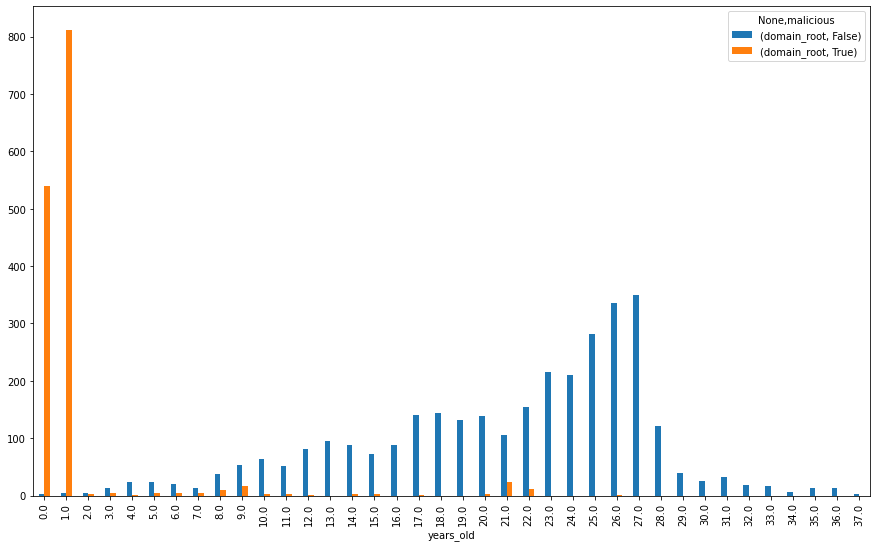

In [44]:
# Review domain age
primary_dataset['years_old'] = primary_dataset['days_since_creation'].apply(lambda x: round(x/365, 0))

age_plot = primary_dataset[['domain_root','years_old', 'malicious']].dropna().groupby(
                            ['years_old', 'malicious']).count().unstack('malicious').plot.bar()
plt.show()

### It's likely that we still have a large number of maliciously registered domains in the resulting dataset.

In [45]:
# Review DNS resolution features.
# Todo: Load in record count data.
print("Number of Unique DNS A Record Orgs: " + str(primary_dataset['dns_rec_a_org'].nunique()))
print("Number of Unique DNS A Record Country Codes: " + str(primary_dataset['dns_rec_a_cc'].nunique()))
print("Number of Unique DNS MX Record Orgs: " + str(primary_dataset['dns_rec_mx_org'].nunique()))
print("Number of Unique DNS A Record Country Codes: " + str(primary_dataset['dns_rec_mx_cc'].nunique()))

Number of Unique DNS A Record Orgs: 947
Number of Unique DNS A Record Country Codes: 59
Number of Unique DNS MX Record Orgs: 564
Number of Unique DNS A Record Country Codes: 50


In [46]:
# Load raw DNS data since it's not in the processed csv.
data_dir = '../data/raw/'

# Gather a list of data files
data_file_list = []
for filename in os.listdir(data_dir):
    if filename.startswith("benign_dns") | filename.startswith("malicious_dns"):
        f = os.path.join(data_dir, filename)
        if os.path.isfile(f):
            data_file_list.append((f, filename))
            
# Load data into memory via dict referenced by filename
data_file_dict = {}
for data_file in data_file_list:
    with open(data_file[0]) as f:
        data = f.read()
        
        data_list = []
        while True:
            obj, remaining = parse_json(data)
            data_list.append(obj)
            data = remaining
            if not remaining.strip():
                break
        data_file_dict[data_file[1]] = data_list

In [47]:
# Load DNS data into dataframe, add type column, and merge
benign_dns_resolution_data = data_file_dict['benign_dns_resolution_data.txt']
malicious_dns_resolution_data = data_file_dict['malicious_dns_resolution_data.txt']

reformed_benign_dns_resolution_dict = {}
for dns_resolution_dict in benign_dns_resolution_data:
    for outerKey, innerDict in dns_resolution_dict.items():
        for innerKey, values in innerDict.items():
            reformed_benign_dns_resolution_dict[(outerKey, innerKey)] = values

benign_dns_resolution_df = pd.DataFrame(reformed_benign_dns_resolution_dict).T.stack().unstack(level=0).T

reformed_malicious_dns_resolution_dict = {}
for dns_resolution_dict in malicious_dns_resolution_data:
    for outerKey, innerDict in dns_resolution_dict.items():
        for innerKey, values in innerDict.items():
            reformed_malicious_dns_resolution_dict[(outerKey, innerKey)] = values

malicious_dns_resolution_df = pd.DataFrame(reformed_malicious_dns_resolution_dict).T.stack().unstack(level=0).T

dns_resolution_df = pd.concat([benign_dns_resolution_df, malicious_dns_resolution_df])
#dns_resolution_df = dns_resolution_df.reset_index().rename(columns={'index': 'domain'})
dns_resolution_df.columns = dns_resolution_df.columns.droplevel()
dns_resolution_df.columns = ['a_ip', 'dns_rec_a_count', 'mx_ip', 'dns_rec_mx_count']

# Create feature for if domain had A or MX record. Assuming right now that if one were available,
# we would have captured it.
dns_resolution_df['dns_rec_a_exists'] = np.where(dns_resolution_df['a_ip'] == 'NA', False, True)
dns_resolution_df['dns_rec_mx_exists'] = np.where(dns_resolution_df['mx_ip'] == 'NA', False, True)
# Drop IP's, not needed here.
dns_resolution_df.drop(columns=['a_ip', 'mx_ip'], inplace=True)

In [48]:
dns_resolution_df

,dns_rec_a_count,dns_rec_mx_count,dns_rec_a_exists,dns_rec_mx_exists
000webhost.com,2,5,True,True
000webhostapp.com,1,1,True,True
1.bp.blogspot.com,1,0,True,False
123-reg-new-domain.co.uk,0,0,False,False
12371.cn,2,0,True,False
...,...,...,...,...
zuwevex.com,0,0,False,False
zyokao27.top,0,0,False,False
zyonou41.top,0,0,False,False
zyoskv38.top,0,0,False,False


In [49]:
# Join DNS resolution data with primary_dataset.
primary_dataset = primary_dataset.join(dns_resolution_df, on='domain', how='inner')

In [50]:
# Carve off some features to focus on.
primary_dataset_eda = primary_dataset.copy()
important_feature_list = ['registrar', 'malicious', 'days_between_creations', 'days_since_creation', 'days_between_updates', 'days_since_update', 'days_until_expiration', 'length', 'uncommon_letters', 'word_count', 'word_ratio']
primary_dataset_eda = primary_dataset_eda[important_feature_list]
primary_dataset_eda['registrar'] = primary_dataset_eda['registrar'].astype(str)

In [51]:
# One-hot encode features
lb = LabelBinarizer()
primary_dataset_eda = primary_dataset_eda.join(pd.DataFrame(lb.fit_transform(primary_dataset_eda['registrar']),
                            index=primary_dataset_eda.index, columns=lb.classes_))
primary_dataset_eda.drop(columns=['registrar'], inplace=True)

In [52]:
primary_dataset_eda

,malicious,days_between_creations,days_since_creation,days_between_updates,days_since_update,days_until_expiration,length,uncommon_letters,word_count,word_ratio,...,"ТОВ ""Сервіс Онлайн""",北京东方网景信息科技有限公司,北京中科三方网络技术有限公司,北京国旭网络科技有限公司,北京新网数码信息技术有限公司,厦门三五互联科技股份有限公司,厦门易名科技股份有限公司,广东耐思智慧科技有限公司,成都西维数码科技有限公司,阿里云计算有限公司（万网）
domain,,,,,,,,,,,,,,,,,,,,,
000webhost.com,False,0.0,5422.0,0.0,307.0,57.0,10,1,4,0.400000,...,0,0,0,0,0,0,0,0,0,0
000webhostapp.com,False,0.0,2147.0,0.0,70.0,1870.0,13,1,4,0.307692,...,0,0,0,0,0,0,0,0,0,0
0ffline.offes.co.uk,True,0.0,9370.0,0.0,6341.0,NaN,12,0,4,0.333333,...,0,0,0,0,0,0,0,0,0,0
1.baiduyuna.tk,True,NaN,NaN,NaN,NaN,NaN,10,0,0,0.000000,...,0,0,0,0,0,0,0,0,0,0
1.bp.blogspot.com,False,0.0,7910.0,0.0,272.0,125.0,12,0,4,0.333333,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuwevex.com,True,0.0,212.0,0.0,197.0,153.0,7,3,4,0.571429,...,0,0,0,0,0,0,0,0,0,0
zyokao27.top,True,1.0,91.0,17.0,75.0,274.0,8,1,0,0.000000,...,0,0,0,0,0,0,0,0,0,0
zyonou41.top,True,1.0,91.0,17.0,75.0,274.0,8,1,0,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [53]:
# Drop NaN for now
print("Number of records pre-NaN drop: " + str(len(primary_dataset_eda)))
primary_dataset_eda.dropna(inplace=True)
print("Number of records post-NaN drop: " + str(len(primary_dataset_eda)))
y_col = 'malicious'
y = primary_dataset_eda[y_col]
X = primary_dataset_eda[primary_dataset_eda.columns.drop(y_col)]
primary_dataset_eda.reset_index().groupby('malicious')['domain'].count()

Number of records pre-NaN drop: 9166
Number of records post-NaN drop: 7273


malicious
False    4843
True     2430
Name: domain, dtype: int64

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [55]:
stage2_model = RandomForestClassifier(random_state=random_seed)
stage2_model.fit(X_train, y_train)
yhat = stage2_model.predict(X_test)
acc = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % acc)
confusion_matrix(y_test, yhat)

Accuracy: 0.995


array([[997,   3],
       [  4, 451]])

In [56]:
#importance = stage2_model.feature_importances_
#for i,v in enumerate(importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))
#plt.bar([x for x in range(len(importance))], importance)
#plt.show()
features = {}
for feature, importance in zip(X.columns, stage2_model.feature_importances_):
    features[feature] = importance
dict(sorted(features.items(), key=lambda item: item[1], reverse=True))

{'days_since_creation': 0.41722506571361634,
 'days_since_update': 0.10143023827272507,
 'days_until_expiration': 0.09434998516182937,
 'Key-Systems GmbH': 0.06138205400744694,
 'length': 0.061295172634182195,
 'Porkbun LLC': 0.02990086241635645,
 'word_ratio': 0.026707351687641,
 'CSC CORPORATE DOMAINS, INC.': 0.020375586002473557,
 'word_count': 0.020052523664991103,
 'days_between_updates': 0.018607662822829895,
 'NAMECHEAP INC': 0.017875014461172012,
 'MarkMonitor, Inc.': 0.01746151658436083,
 'NICENIC INTERNATIONAL GROUP CO., LIMITED': 0.016220798067934535,
 'CNOBIN INFORMATION TECHNOLOGY LIMITED': 0.01337172935692834,
 'GoDaddy.com, LLC': 0.007354736651399934,
 'Network Solutions, LLC': 0.0068912493464180595,
 'uncommon_letters': 0.006839360559388602,
 'days_between_creations': 0.006247528871563887,
 'Vitalwerks Internet Solutions, LLC / No-IP.com': 0.004665003555315272,
 'Vitalwerks Internet Solutions, LLC DBA No-IP': 0.003876765051590264,
 'Ascio Technologies, Inc': 0.003581478

In [57]:
# Let's remove age and see the results
primary_dataset_eda.drop(columns=['days_between_creations', 'days_since_creation', 'days_between_updates', 'days_since_update', 'days_until_expiration'], inplace=True)

In [58]:
y_col = 'malicious'
y = primary_dataset_eda[y_col]
X = primary_dataset_eda[primary_dataset_eda.columns.drop(y_col)]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [59]:
stage2_model = RandomForestClassifier(random_state=random_seed)
stage2_model.fit(X_train, y_train)
yhat = stage2_model.predict(X_test)
acc = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % acc)
confusion_matrix(y_test, yhat)

Accuracy: 0.973


array([[955,  19],
       [ 20, 461]])

In [60]:
#importance = stage2_model.feature_importances_
#for i,v in enumerate(importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))
#plt.bar([x for x in range(len(importance))], importance)
#plt.show()

features = {}
for feature, importance in zip(X.columns, stage2_model.feature_importances_):
    features[feature] = importance
dict(sorted(features.items(), key=lambda item: item[1], reverse=True))

{'Key-Systems GmbH': 0.1585981904905036,
 'length': 0.14600696706249633,
 'word_ratio': 0.08777781627993747,
 'Porkbun LLC': 0.0858298496428614,
 'word_count': 0.051548362441521924,
 'NICENIC INTERNATIONAL GROUP CO., LIMITED': 0.051519851347998705,
 'NAMECHEAP INC': 0.04805535468988821,
 'MarkMonitor, Inc.': 0.04711927110197802,
 'CSC CORPORATE DOMAINS, INC.': 0.0357668780378891,
 'CNOBIN INFORMATION TECHNOLOGY LIMITED': 0.033156344233072683,
 'GoDaddy.com, LLC': 0.027872413779557816,
 'Network Solutions, LLC': 0.023674667675345925,
 'uncommon_letters': 0.023335012146712217,
 'Hosting Concepts B.V. d/b/a Registrar.eu': 0.017755091812171386,
 'NameSilo, LLC': 0.014577291830872757,
 'ERANET INTERNATIONAL LIMITED': 0.012462779690737558,
 'TUCOWS, INC.': 0.00728001506434526,
 'GANDI SAS': 0.007193366904616927,
 'Ascio Technologies, Inc': 0.006676511195483743,
 'Registrar of domain names REG.RU LLC': 0.006295872085230398,
 'PDR Ltd. d/b/a PublicDomainRegistry.com': 0.005456347584972698,
 'S